# Applying PCA to CDT Images

Tutorial นี้จะเป็นตัวอย่างการนำเอา PCA มาลองลดจำนวนมิติของข้อมูลที่เป็นรูปภาพ clock drawing test (CDT) กันดู

ข้อมูลรูปภาพนี้เป็นภาพที่เก็บมาจากอาสาสมัคร/ผู้ป่วยในโรงพยาบาลจุฬาลงกรณ์ โดยตอนเก็บข้อมูล คณะผู้วิจัยได้แจ้งให้อาสาสมัคร/ผู้ป่วยวาดภาพนาฬิกาที่มีเข็มชี้ไปที่เวลา 11:10 น หลังจากนั้นคณะผู้วิจัยก็จะนำเอาภาพที่ถูกวาดแต่ละอันมาให้คะแนนที่เรียกว่า Shulman score (คะแนน 0 ถึง 5) ภาพวาดที่มีความผิดปกติจะได้รับคะแนนน้อย เช่น ดูไม่ออกว่าเป็นนาฬิกา หรือ เป็นภาพนาฬิกาก็จริง แต่บอกเวลาผิด ส่วนภาพที่ไม่มีความผิดปกติจะได้คะแนนสูง


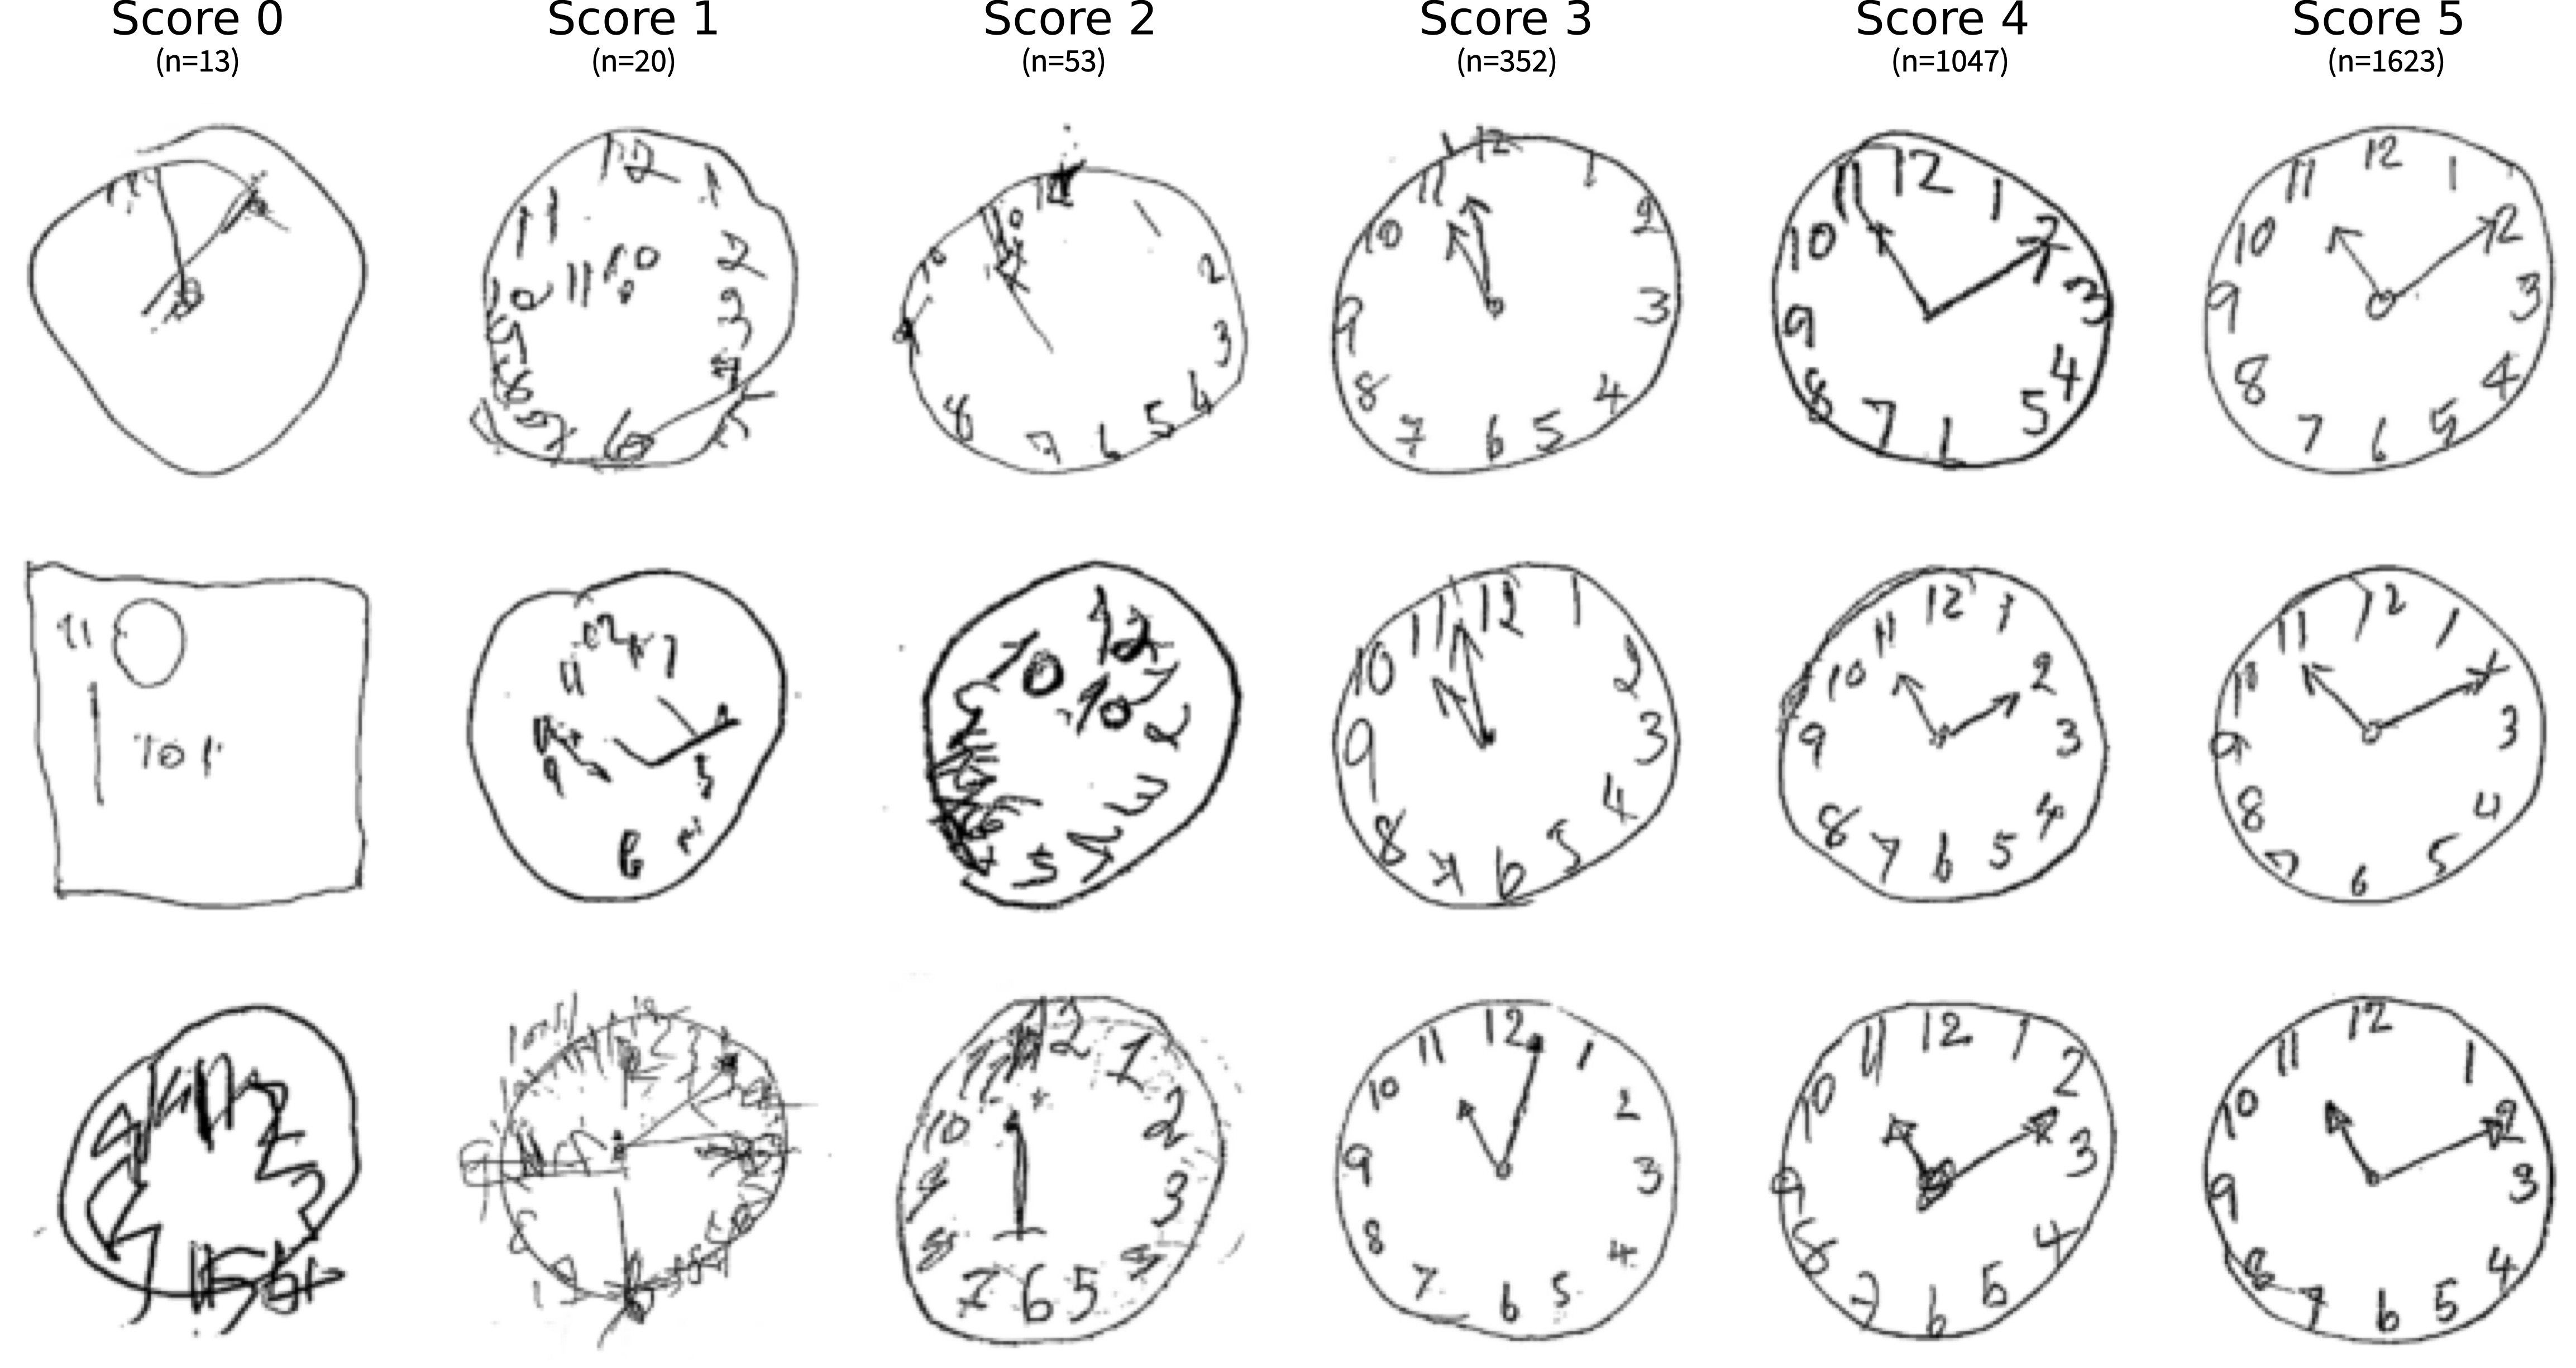

ข้อมูลที่เราใช้ในตัวอย่างนี้จะเป็นข้อมูลที่ถูกนำมา process เพิ่มเติม โดยจะมีรายละเอียดดังนี้
1. ดาวน์โหลดภาพ CDT จาก https://github.com/cccnlab/CDT-API-Network
2. สุ่มเลือกภาพที่ได้รับ Shulman score เป็น 5 มาเป็นจำนวน 30 ภาพ และเรียกว่าเป็น class 0 (ภาพวาดที่นาฬิกาดูปกติดี)
3. สุ่มเลือกภาพที่ได้รับ Shulman score เป็น 0 หรือ 1 มาเป็นจำนวนรวมกัน 30 ภาพ และเรียกว่าเป็น class 1 (ภาพวาดมีความผิดปกติ)
4. ภาพทุกภาพ (มีทั้งหมด 60 ภาพ) ถูก resize ให้มีขนาดเป็น 48 x 48 pixels

---


เริ่มต้นด้วยการ Download ข้อมูลผ่านคำสั่ง `wget`

In [1]:
!wget -O images.pickle https://github.com/ichatnun/brainCodeCamp2023/raw/main/Fundamentals/DimensionalityReduction/data/CDT/clock_images.pickle
!wget -O labels.pickle https://github.com/ichatnun/brainCodeCamp2023/raw/main/Fundamentals/DimensionalityReduction/data/CDT/labels.pickle

--2023-06-27 13:44:32--  https://github.com/ichatnun/brainCodeCamp/raw/main/Fundamentals/DimensionalityReduction/data/CDT/clock_images.pickle
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ichatnun/brainCodeCamp/main/Fundamentals/DimensionalityReduction/data/CDT/clock_images.pickle [following]
--2023-06-27 13:44:32--  https://raw.githubusercontent.com/ichatnun/brainCodeCamp/main/Fundamentals/DimensionalityReduction/data/CDT/clock_images.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1106083 (1.1M) [application/octet-stream]
Saving to: ‘images.pickle’

images.pickle       100%[==========

Import สิ่งที่เราจะใช้งาน

In [2]:
import pickle
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import colors

นำเอาข้อมูลที่ได้ดาวน์โหลดไว้ มาเก็บไว้ใน variables

In [3]:
with open('images.pickle', 'rb') as handle:
    images = pickle.load(handle)
with open('labels.pickle', 'rb') as handle:
    labels = pickle.load(handle)

ลองสำรวจขนาดของข้อมูลรูปภาพและคะแนนของรูปภาพว่าเป็นไปตามที่คาดหวังไว้หรือไม่

**หมายเหตุ** ในหลาย ๆ ครั้งเราจะได้ยินคนใช้คำว่า label แทนคำว่า class โดยเฉพาะเมื่อเราแก้โจทย์ classification

In [4]:
print(f"Images: {images.shape}")
print(f"Labels: {labels.shape}")
print(f"There are {images.shape[0]} samples. \nEach sample is an image of size {images.shape[1:]}.")

Images: (60, 48, 48)
Labels: (60,)
There are 60 samples. 
Each sample is an image of size (48, 48).


ลอง display รูปภาพจากแต่ละ label มาดู


*   label = 0 คือภาพนาฬิกาที่ดูปกติดี
*   label = 1 คือภาพนาฬิกาที่ดูผิดปกติ ซึ่งเป็นหนึ่งในข้อบ่งชี้ว่าผู้วาดอาจมีภาวะสมองเสื่อม

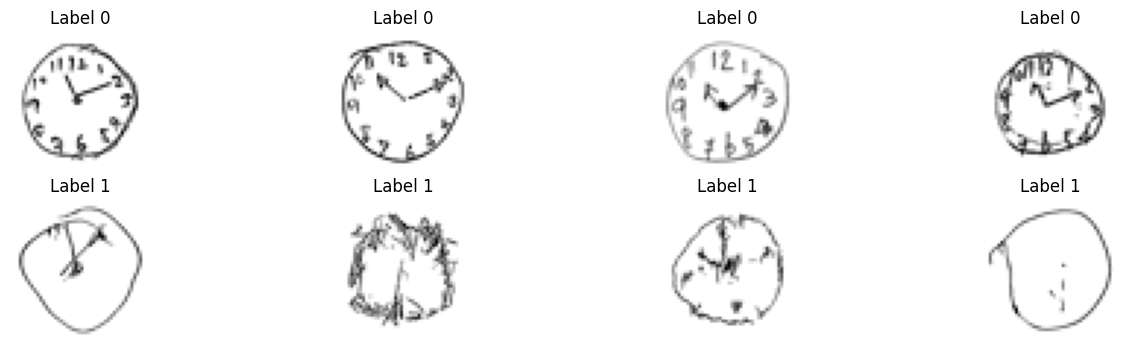

In [5]:
num_img_to_display = 4
fig, ax = plt.subplots(2, num_img_to_display, figsize=(4*num_img_to_display, 4))

for curr_label in [0, 1]:
    curr_images = images[labels == curr_label, :][:num_img_to_display, :]

    for idx_img in range(num_img_to_display):
        ax[curr_label, idx_img].imshow(curr_images[idx_img], cmap='gray')
        ax[curr_label, idx_img].set_axis_off()
        ax[curr_label, idx_img].set_title(f"Label {curr_label}")

เราจะใช้ค่าของแต่ละ pixel ในรูปภาพเป็น feature ที่จะถูกนำไปใช้กับ PCA ส่งผลให้เรามีจำนวน features ทั้งหมด 48 x 48 = 2,304 ต่อหนึ่งรูปภาพ

กล่าวคือ รูปภาพของเราแต่ละภาพ เป็นจุดข้อมูลที่อยู่ใน space ที่มีขนาด 2,304 มิติ

In [6]:
# เตรียมข้อมูลที่มีการจัดเรียงมิติสอดคล้องกับความต้องการของ PCA (n_samples, n_features)
images_flatten = np.reshape(images, (images.shape[0],-1))
print(f"Current shape of our data: {images_flatten.shape}")

Current shape of our data: (60, 2304)


เรียกใช้ `sklearn.decomposition.PCA` โดยกำหนกได้ `n_components` มีค่าเป็น 2 เพื่อหาแกนมาลดมิติของข้อมูลจาก 2,304 มิติ ต่อหนึ่งจุดข้อมูล ลงเหลือ 2 มิติ โดยการใช้ PCA ในที่นี้จะเห็นได้ว่า PCA แปลงข้อมูลโดยไม่ได้ใช้ข้อมูล labels เลย

In [7]:
model_PCA = PCA(n_components=2, whiten=True, random_state=20)
images_PCA = model_PCA.fit_transform(images_flatten)

print(f"% variance captured by PC1 = {model_PCA.explained_variance_ratio_[0]*100: 0.2f}")
print(f"% variance captured by PC2 = {model_PCA.explained_variance_ratio_[1]*100: 0.2f}")

% variance captured by PC1 =  8.84
% variance captured by PC2 =  7.58


ลองนำผลลัพธ์ที่ได้มา plot ดูว่าข้อมูลมีการกระจายตัวหรือกระจุกตัวกันอย่างไร

**หมายเหตุ** แต่ละจุด 1 จุดใน plot คือ ภาพนาฬิกาแต่ละภาพที่ถูกลดมิติลงจนเหลือ 2 มิติ ดังนั้น จำนวนจุดที่เรามีใน plot ก็คือจะเท่ากับจำนวนรูปภาพที่เรามีใน dataset ของเรานั่นเอง

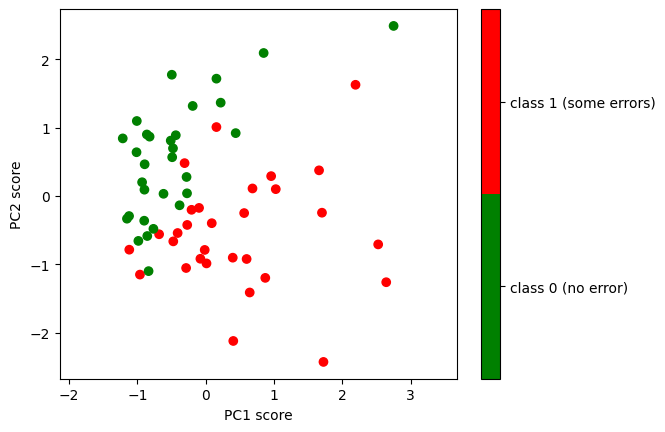

In [8]:
# กำหนดสีให้แต่ละ class โดยใช้สีแดงแสดง class 1 (มีความผิดปกติ) และสีเขียวแสดง class 0 (ไม่มีความผิดปกติที่เห็นได้จากภาพวาด)
custom_cmap = colors.ListedColormap(["green","red"])

plt.figure()
plt.scatter(images_PCA[:, 0], images_PCA[:,1], c=labels, cmap=custom_cmap)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2), labels=['class 0 (no error)', 'class 1 (some errors)'])
plt.xlabel('PC1 score')
plt.ylabel('PC2 score')
plt.show()

จะเห็นได้ว่าข้อมูลภาพนาฬิกาที่ถูกลดมิติลงจาก 2,304 มิติ เหลือแค่ 2 มิติ โดยการใช้ PCA มีการแบ่งกันเป็นสองกลุ่มได้ดีพอสมควร โดยที่ PCA ไม่ได้ใช้ข้อมูล labels ในการลดจำนวนมิติเลย

**ผู้จัดเตรียม code ใน tutorial**: ดร. อิทธิ ฉัตรนันทเวช